In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import plotly as py
import plotly.graph_objs as go
import bqplot
import ipywidgets

from plotly.offline import iplot
from plotly.graph_objs.scatter.marker import ColorBar
from IPython.core.display import display

py.offline.init_notebook_mode(connected=True)
DATA_PATH = "./data.csv"
df = pd.read_csv(DATA_PATH,)

# IMDb Movie Data Visualization

This project is based on a dataset retrieved from data.world [(source)](https://data.world/data-society/imdb-5000-movie-dataset) that contains 5000+ movies scraped from the Internet Movie Database (IMDb). The dataset provides detailed information for each movie in its 28 columns, including movie title, duration, genres, content rating, language, country, title year, gross, budget, director information, actor information, IMDb rating, Facebook likes and so on. It covers movies from 65 countries and areas and released from the year 1916 to 2016, which enables us to conduct research based on plenty of interesting ideas.
In order to explore different topics, we divided our project into five parts that we are most interested in, which are:

1. What movie genres are most loved and profitable
2. What is the correlation between movie gross and directors
3. What kind of movies have more faces in poster
4. How budget and director & actors' popularity affect a movie's profit
5. How do top movies develop over time and what movie factors have a stronger correlation

We generated visualizations in each part to help us find the correlation among various movie factors. The plots we used include box plots, bar charts, heat maps, and scatter plots. We also implemented interactions to better visualize the data we explored.

# How to run this project

* To avoid dependencies conflict issues, we STRONGLY RECOMMENDED you init a new virtual env and install all the dependencies through the `requirements.txt` file.

* If some images don't show automatically, try to execute every cell manually (from the first cell to the end).

# Part-1: What Movie Genres are Most Loved and Profitable

- In this section, we use boxplot to explore what genres of movie are most loved and profitable.
- In the raw data, each movie can have multiple genres (split by |). We choose the first genre as representative.
- We use Return on Investment(ROI) to evaluate profitability. The formula is

```
          (Gross - Budget)  
ROI =  ---------------------- X 100%
               Budget 
```

In [2]:
# ===== data process block =====

# sub dataframe
sub_df = df[["genres","gross","budget","imdb_score"]].dropna()

# add extra columns
sub_df["genres_cln"] = sub_df["genres"].str.split("|").str[0]
sub_df["roi"] = (sub_df["gross"]-sub_df["budget"])*100 / sub_df["budget"]

# process genres 
genres = sub_df["genres_cln"].unique()
# remove genres with count less than 40
THRESHOLD = 40
genres_cln = list()
for g in genres:
    if len(sub_df.loc[sub_df["genres_cln"]== g ])>THRESHOLD :
        genres_cln.append(g)
        
# arrays for boxplot
arrays_imdb_score = [ sub_df.loc[sub_df["genres_cln"]==v]["imdb_score"] for v in genres_cln]
arrays_roi = [ sub_df.loc[sub_df["genres_cln"]==v]["roi"] for v in genres_cln]

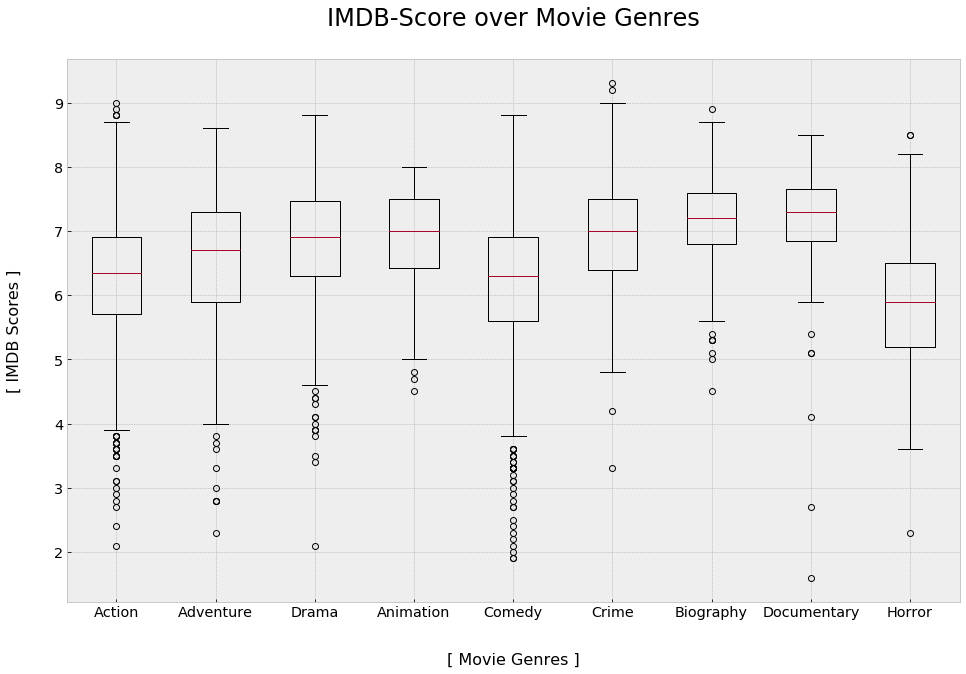

In [3]:
# ===== plot:IMDB-Score over Movie Genres  =====

# import data
genres_cln = genres_cln
arrays_imdb_score = arrays_imdb_score

# style
PLT_STYLE = "bmh"
RC_PARAMS = {
    "figure.figsize" : (16,10),
    "axes.labelsize" : 16,
    "axes.titlesize" : 24,
    "xtick.labelsize": 'x-large',
    "ytick.labelsize": 'x-large'
}
plt.style.use(PLT_STYLE)
plt.rcParams.update(RC_PARAMS)

# meta data
plt.title("IMDB-Score over Movie Genres",y=1.05)
plt.xlabel("[ Movie Genres ]",labelpad=32)
plt.ylabel("[ IMDB Scores ]",labelpad=32)

# plot
plt.boxplot(arrays_imdb_score)
plt.xticks([v for v in range(1,len(genres_cln)+1)],genres_cln)
plt.show()

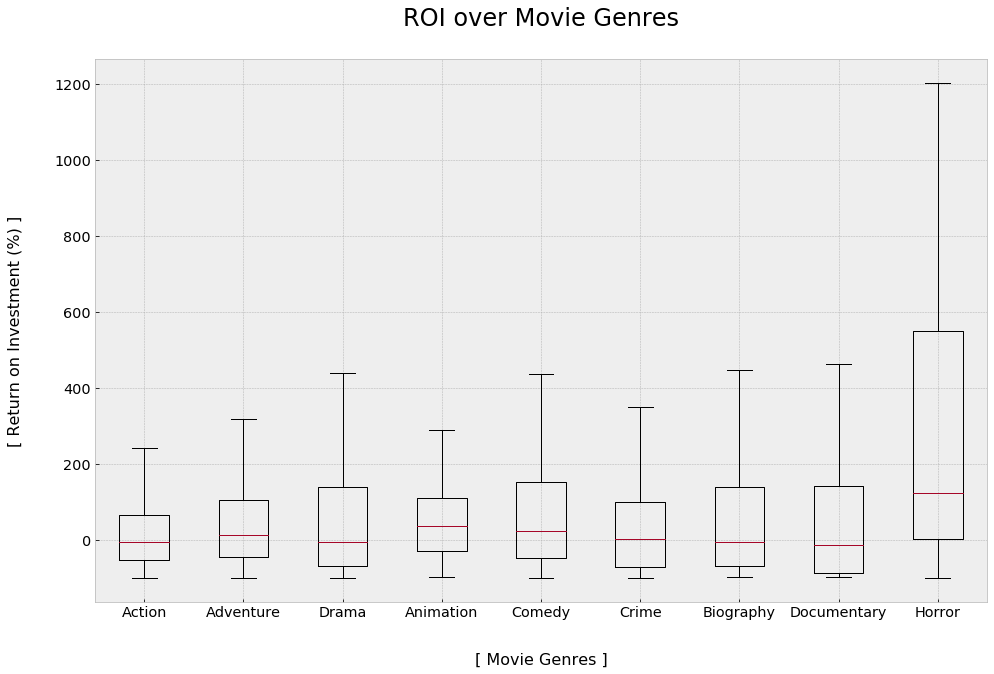

In [4]:
# ===== plot: ROI over Movie Genres  =====

# import data
genres_cln = genres_cln
arrays_roi = arrays_roi

# style
PLT_STYLE = "bmh"
RC_PARAMS = {
    "figure.figsize" : (16,10),
    "axes.labelsize" : 16,
    "axes.titlesize" : 24,
    "xtick.labelsize": 'x-large',
    "ytick.labelsize": 'x-large'
}
plt.style.use(PLT_STYLE)
plt.rcParams.update(RC_PARAMS)

# meta data
plt.title("ROI over Movie Genres",y=1.05)
plt.xlabel("[ Movie Genres ]",labelpad=32)
plt.ylabel("[ Return on Investment (%) ]",labelpad=32)
plt.margins(y=0.05)

# plot
plt.boxplot(arrays_roi, showfliers=False)
plt.xticks([v for v in range(1,len(genres_cln)+1)],genres_cln)
plt.show()

# ========================= END OF SECTION =========================

# Part-2 Director Analysis

We want to present the total gross for directors, the mean IMDB Movie scores for directors who have more than 4 movies, total gross for different countries and mean IMDB Movie scores for different countries. Our idea is to define a function to process the data. Our function is in the cell below, and there are 4 variables in the function: name, value, types and number of films. "Name" refers to the column(catogorical data) name that we are going to analyse. "Value" refers to another column(numerical data). "Types" refers to the way how we are going to deal with the grouped data. There are three types: mean, median and sum. "Number of films" is a variable that refers to the limitation. For example, there are a lot of directors in the dataset, some of them only have one film product, which is not representative. The directors who have produced more films might have more points to analyze.With this function, we can present multiple analysis, which is extensive. The "process_compared_data" is mainly to create the dataset which is going to be compared. And than we use matplotlib to show the results. 

Reference: https://github.com/mrunmayeeshukla/Data-visualization-for-IMDB-movies-

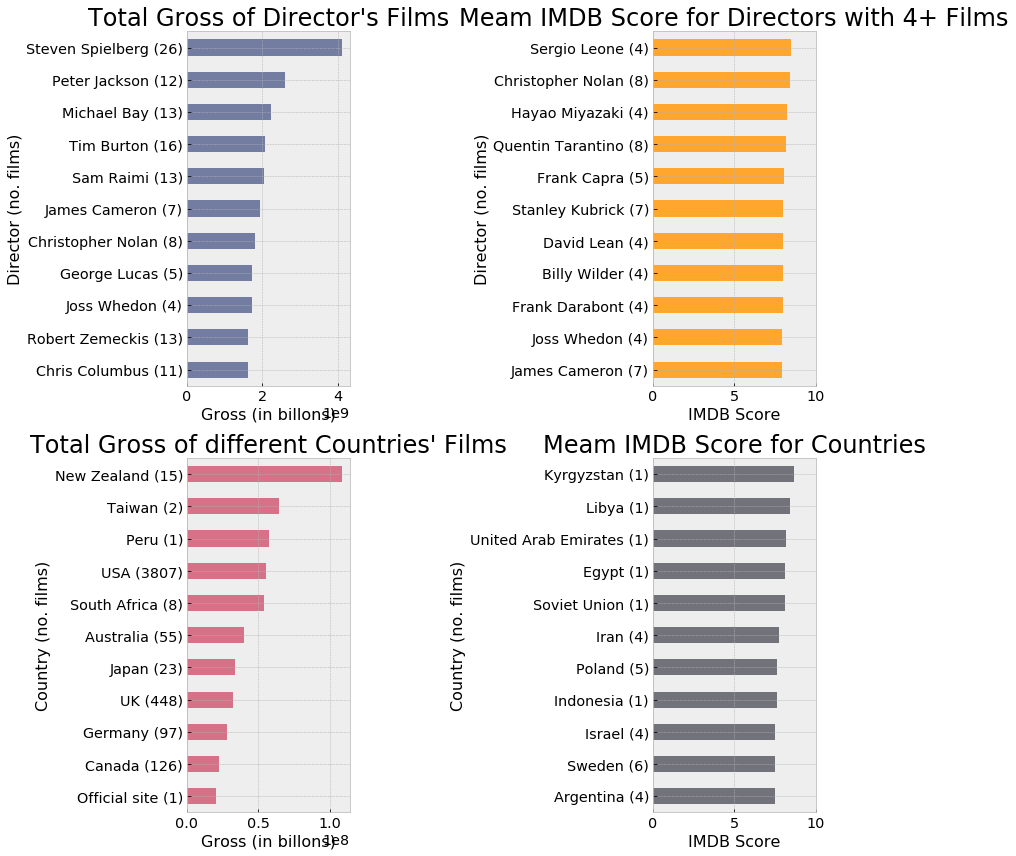

In [5]:
def process_compared_data(name, value, types, no_films):  
    comparison_df = df.groupby(name, as_index=False)
    if types == 'mean':
        comparison_df = comparison_df.mean()
    elif types == 'median':
        comparison_df = comparison_df.median()
    if types == 'sum':
        comparison_df = comparison_df.sum() 

    name_count_key = df[name].value_counts().to_dict()
    comparison_df['films'] = comparison_df[name].map(name_count_key)
    comparison_df.sort_values(value, ascending=False, inplace=True)
    comparison_df[name] = comparison_df[name].map(str) + " (" + comparison_df['films'].astype(str) + ")"
   
    compared_df = comparison_df[comparison_df['films'] >= no_films][[name, value]][10::-1].set_index(name).iloc[:,0]
    
    return compared_df


fig = plt.figure(figsize=(18,12))

plt.subplot2grid((2,3),(0,0), rowspan = 1)
process_compared_data('director_name','gross','sum', 0).plot(kind='barh', color='#737CA1')
plt.legend().set_visible(False)
plt.title("Total Gross of Director's Films")
plt.ylabel("Director (no. films)")
plt.xlabel("Gross (in billons)")

plt.subplot2grid((2,3),(0,1), rowspan = 1)
process_compared_data('director_name','imdb_score','mean', 4).plot(kind='barh', color='#FFA62F')
plt.legend().set_visible(False)
plt.title('Meam IMDB Score for Directors with 4+ Films')
plt.ylabel("Director (no. films)")
plt.xlabel("IMDB Score")
plt.xlim(0,10)

plt.subplot2grid((2,3),(1,0), rowspan = 1)
process_compared_data('country','gross','mean', 0).plot(kind='barh', color='#D57288')
plt.legend().set_visible(False)
plt.title("Total Gross of different Countries' Films")
plt.ylabel("Country (no. films)")
plt.xlabel("Gross (in billons)")

plt.subplot2grid((2,3),(1,1), rowspan = 1)
process_compared_data('country','imdb_score','mean', 0).plot(kind='barh', color='#72737A')
plt.legend().set_visible(False)
plt.title('Meam IMDB Score for Countries')
plt.ylabel("Country (no. films)")
plt.xlabel("IMDB Score")
plt.xlim(0,10)

plt.tight_layout()

We want to present the difference of gross and budget value for directors. Basically, we used Dataframes in Python to process the data: we add another column which is the difference of gross and the budget. And then, we grouped the data by the "director name". And we sum up the diffence of gross and the budget based for each director based on the grouped data. We get a form: the row is referring to a year, and the columns refer to different directors. We then used heatmap to present the analyzed result. 

Reference: https://github.com/innat/IMDB-Analysis

Text(113.5, 0.5, 'Year')

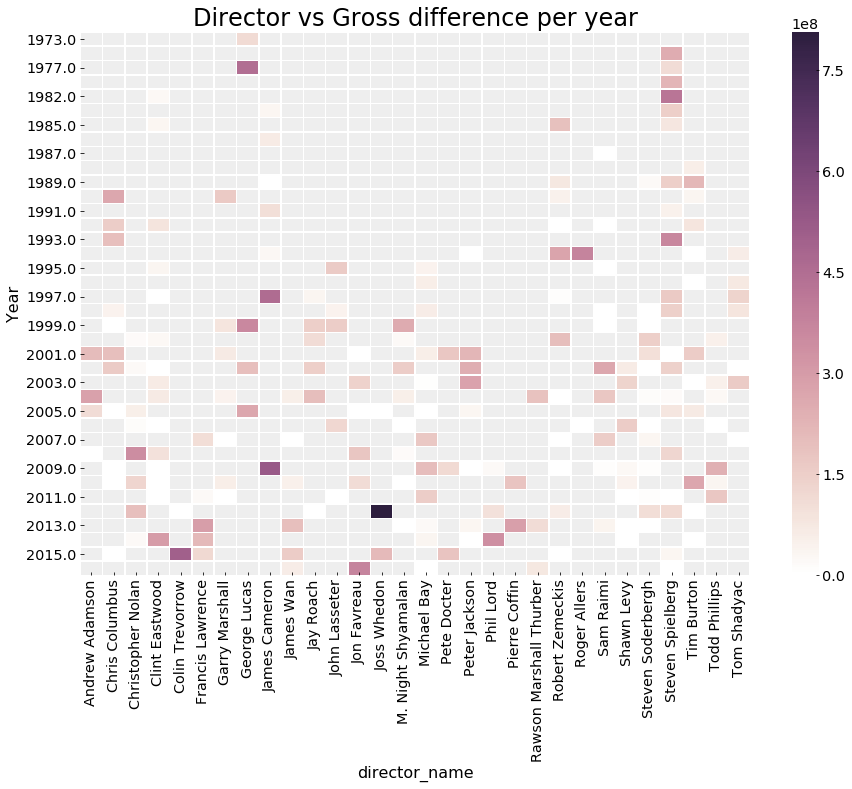

In [6]:
df_copy = df.copy().dropna()
df_copy['diff_gross']=df_copy['gross']-df_copy['budget']
director_budget = df_copy.groupby(df_copy['director_name'])['diff_gross'].sum()
direcotr_budget_indx= director_budget.sort_values(ascending= False)[:30].index
director_budget_pivot= pd.pivot_table(data=df_copy[df_copy['director_name'].isin(direcotr_budget_indx)],
                          index=['title_year'], 
                          columns=['director_name'], 
                          values= ['diff_gross'],
                          aggfunc='sum')
director_budget_pivot.head()

plt.subplots(figsize=(15,10))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(director_budget_pivot['diff_gross'],vmin=0,annot=False,linewidth=.5,cmap=cmap)
plt.title('Director vs Gross difference per year')
plt.ylabel('Year')

# ========================= END OF SECTION =========================

# Part-3 What Kind of Movie Has Bigger Number of Faces in Poster?

- In this section, we explore the correlation among face numbers in poster, genre, and content rating by generating a scatter plot

- We use different sizes & colors of scatters to represent the average face numbers in posters of each genre & content rating

In [7]:
# ===== data process =====

# sub dataframe
sub_df = df[["genres","content_rating","facenumber_in_poster"]].dropna()

# filter valid content ratings
invalid_content_ratings = ["Unrated", "Not Rated", "Approved", "Passed"]
sub_df = sub_df[np.isin(sub_df["content_rating"], invalid_content_ratings, invert=True)]

# axes
genres = sub_df["genres"].str.split("|").str[0].unique()
content_ratings = sub_df["content_rating"].unique()

# aggregrate for scatter plot
multi_index = pd.MultiIndex.from_product([genres, content_ratings], names=["genres", "content_ratings"])
sum_num_faces = pd.Series(0, index=multi_index)
count_movies = pd.Series(0, index=multi_index)

for i in range(len(sub_df.index)):
    row = sub_df.iloc[i]
    content_rating = row["content_rating"]
    num_faces = row["facenumber_in_poster"]
    for genre in row["genres"].split("|"):
        if (genre, content_rating) not in count_movies.index.tolist():
            continue
        sum_num_faces.loc[genre, content_rating] += num_faces
        count_movies.loc[genre, content_rating] += 1

count_movies[count_movies < 3] = np.nan
avg_num_faces = sum_num_faces / count_movies
avg_num_faces = avg_num_faces.fillna(0)

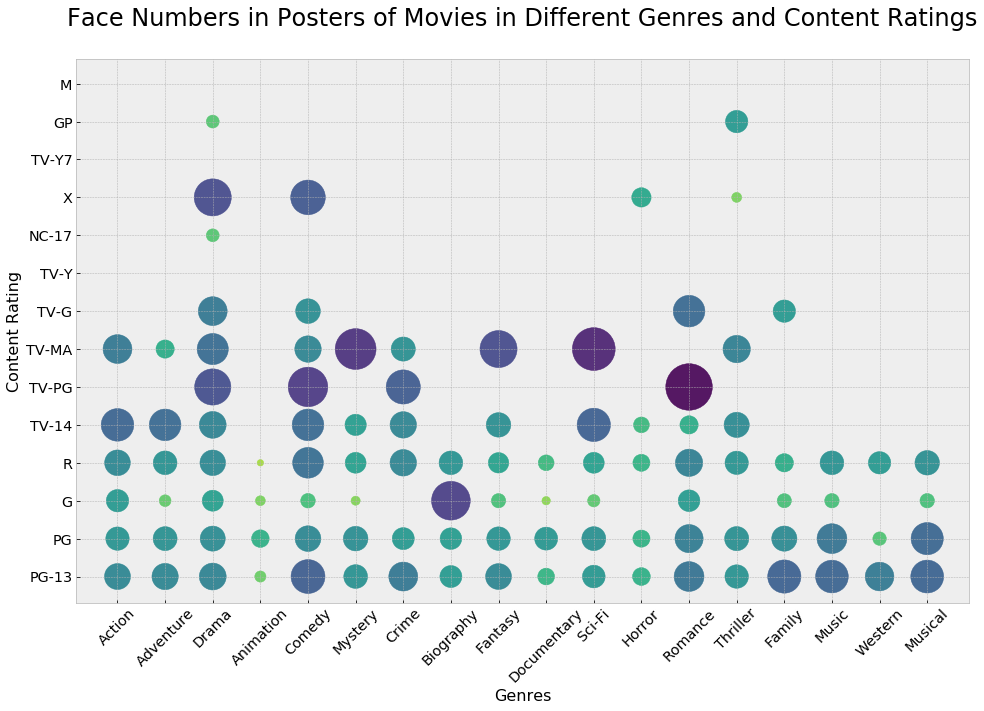

In [8]:
# ===== plot: Face Numbers in Posters v.s. Genres v.s. Content Ratings =====

# plot parameters
x = []
y = []
for genre, content_rating in avg_num_faces.index.tolist():
    x.append(genre)
    y.append(content_rating)
num_faces = avg_num_faces.values
areas = num_faces * 500
colors = (10 - np.sqrt(num_faces * 2)).transpose()

# plot
figure = plt.scatter(x, y, s=areas, marker="o", c=colors, alpha=0.9)

# style
plt.title("Face Numbers in Posters of Movies in Different Genres and Content Ratings", y=1.05)
plt.xlabel("Genres")
plt.ylabel("Content Rating")
plt.xticks(rotation=45)

plt.show()

# ========================= END OF SECTION =========================

# Part-4 Profit Analysis

## How the budget of the movie affect profit?

* In this section, we used plotly to create the scatter plot and tried to find out the correlation between movie's budget and profit.

* The X-axis is budget and the Y-axis is profit, we also used the markers to represent the average IMDB rating out of 10 given to the specific movie. Moreover, the color bar shows the IMDB rating on the right side of the data visualization.

* We added an additional column "Profit" by subtracting "Budget" from "Gross".

## How the director and actor's popularity affect the movie's profit?

* We defined and created an additional column "director_actor_popularity" by adding the director's facebook likes, the actor1, the actor2, and the actor3's facebook likes.


In [9]:
# ===== data process block =====

# add extra columns
# Profit = gross - budget
df["profit"] = df["gross"] - df["budget"]
# Define the popularity by adding director's facebook likes count and actor's facebook likes count
df["director_actor_popularity"] = df["director_facebook_likes"] + df["actor_1_facebook_likes"] + df["actor_2_facebook_likes"] + df["actor_3_facebook_likes"]

# sub dataframe
sub_df = df[["movie_title","gross","budget","profit","imdb_score","director_actor_popularity"]].dropna()

In [10]:
# Bubble chart for profit vs budget
layout = go.Layout(
    title='Profit vs. Budget',
    xaxis=dict(
        title='Budget',
        gridcolor='rgb(255, 255, 255)',
        range=[0, 4e8],
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    ),
    yaxis=dict(
        title='Profit',
        gridcolor='rgb(255, 255, 255)',
        range=[-10e8, 25e8],
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    )
)

data = [go.Scatter(
    x=sub_df[sub_df.budget>5000].budget.values,
    y=sub_df[sub_df.budget>5000].profit.values, 
    mode='markers',
    text= sub_df[sub_df.budget>5000].movie_title.values, 
    # Average Rating Marker 
    marker=dict(
        size=2.5*(sub_df[sub_df.budget>5000].imdb_score),
        sizeref=1.0,
        color=sub_df[sub_df.budget>5000].imdb_score.values,
                
        colorbar=ColorBar(title='Average Rating<br> &nbsp;' , tickvals=[0,1.5,3,5,7,8.5]),

        showscale=True,
        colorscale='Rainbow'
    ))]
# Plot
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [11]:
# Bubble chart for profit vs budget
layout = go.Layout(
    title='Profit vs. Director & Actor popularity',
    xaxis=dict(
        title='Popularity',
        gridcolor='rgb(255, 255, 255)',
        range=[0,7e5],
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    ),
    yaxis=dict(
        title='Profit',
        gridcolor='rgb(255, 255, 255)',
        range=[-10e8, 25e8],
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    )
)

data = [go.Scatter(
    x=sub_df[sub_df.director_actor_popularity>5000].director_actor_popularity.values,
    y=sub_df[sub_df.director_actor_popularity>5000].profit.values, 
    mode='markers',
    text= sub_df[sub_df.budget>5000].movie_title.values, 
    # Average Rating Marker 
    marker=dict(
        size=2.5*(sub_df[sub_df.budget>5000].imdb_score),
        sizeref=1.0,
        color=sub_df[sub_df.budget>5000].imdb_score.values,
                
        colorbar=ColorBar(title='Average Rating<br> &nbsp;' , tickvals=[0,1.5,3,5,7,8.5]),

        showscale=True,
        colorscale='Rainbow'
    ))]
# Plot
fig = go.Figure(data=data, layout=layout)
iplot(fig)

# ========================= END OF SECTION =========================

## Part-5 (1)TopN IMDB Score / Movie Feedback Likes in each decade

In this section, we use an interactive bar plot to show Top movies. 

Users can use "Field" dropdown to change the indicator (includes 'IMDB Score' and 'Movie Feedback Likes') they want to use, "Decade" dropdown to change the time range, 'TopN' slider to choose how many bars they want to show.

In [12]:
Movie = pd.read_csv(DATA_PATH)

m1 = pd.DataFrame(Movie, columns = ['movie_title','imdb_score','movie_facebook_likes','title_year'])
m1.head()

,movie_title,imdb_score,movie_facebook_likes,title_year
0,Avatar,7.9,33000,2009.0
1,Pirates of the Caribbean: At World's End,7.1,0,2007.0
2,Spectre,6.8,85000,2015.0
3,The Dark Knight Rises,8.5,164000,2012.0
4,Star Wars: Episode VII - The Force Awakens ...,7.1,0,NaN


In [13]:
m1.shape

(5043, 4)

In [14]:
m1.dropna(axis=0, how='any', inplace=True)
m1.shape

(4935, 4)

In [15]:
(min(m1.title_year),max(m1.title_year))

(1916.0, 2016.0)

In [16]:
decade_list = list(range(1910,2016,10))

dropdown_field = ipywidgets.Dropdown(options = ['IMDB Score','Movie Facebook Likes'], value = 'IMDB Score', description = 'Field')
dropdown_decade = ipywidgets.Dropdown(options = decade_list, value = 1950, description = 'Decade')
slider_topn = ipywidgets.IntSlider(min = 1, max = 10, value = 3,description = 'TopN')

x_sc = bqplot.OrdinalScale()
y_sc = bqplot.LinearScale()

x_ax = bqplot.Axis(scale = x_sc,label = 'Movie', tick_rotate = 10)
y_ax = bqplot.Axis(scale = y_sc, orientation = 'vertical',label = 'IMDB Score')

bar_x = m1[(m1.title_year>=1950) & (m1.title_year<1960)].sort_values("imdb_score",ascending = False)[:3]['movie_title']
bar_y = m1[(m1.title_year>=1950) & (m1.title_year<1960)].sort_values("imdb_score",ascending = False)[:3]['imdb_score']

bar = bqplot.Bars(x = bar_x, y = bar_y, scales = {'x': x_sc, 'y': y_sc})
fig = bqplot.Figure(marks = [bar], axes = [x_ax, y_ax])

def Decade_on_change(change):
    
    if change['type'] == 'change' and change['name'] == 'value':
        
        current_decade = int(dropdown_decade.value)
        current_field = str(dropdown_field.value)
        field = ''
        if current_field == 'IMDB Score':
            field = 'imdb_score'
        elif current_field == 'Movie Facebook Likes':
            field = 'movie_facebook_likes'
        current_n = int(slider_topn.value)
        
        bar_x = m1[(m1.title_year>=current_decade) & (m1.title_year<current_decade+10)].sort_values(field,ascending = False)[:current_n]['movie_title']
        bar_y = m1[(m1.title_year>=current_decade) & (m1.title_year<current_decade+10)].sort_values(field,ascending = False)[:current_n][field]

        bar.x = bar_x[:current_n]
        bar.y = bar_y[:current_n]

        #x_ax = bqplot.Axis(scale = x_sc,label = dropdown_field.value)
        #fig.axes = [x_ax, y_ax]
        
def Field_on_change(change):

    if change['type'] == 'change' and change['name'] == 'value':
        
        current_decade = int(dropdown_decade.value)
        current_field = str(dropdown_field.value)
        field = ''
        if current_field == 'IMDB Score':
            field = 'imdb_score'
        elif current_field == 'Movie Facebook Likes':
            field = 'movie_facebook_likes'
        current_n = int(slider_topn.value)
        
        bar_x = m1[(m1.title_year>=current_decade) & (m1.title_year<current_decade+10)].sort_values(field,ascending = False)[:current_n]['movie_title']
        bar_y = m1[(m1.title_year>=current_decade) & (m1.title_year<current_decade+10)].sort_values(field,ascending = False)[:current_n][field]

        bar.x = bar_x[:current_n]
        bar.y = bar_y[:current_n]
        
        y_ax = bqplot.Axis(scale = y_sc, orientation = 'vertical', label = dropdown_field.value)
        fig.axes = [x_ax, y_ax]

def on_slider_change(event):
    
    current_decade = int(dropdown_decade.value)
    current_field = str(dropdown_field.value)
    field = ''
    if current_field == 'IMDB Score':
        field = 'imdb_score'
    elif current_field == 'Movie Facebook Likes':
        field = 'movie_facebook_likes'
    current_n = int(slider_topn.value)
    
    bar_x = m1[(m1.title_year>=current_decade) & (m1.title_year<current_decade+10)].sort_values(field,ascending = False)[:current_n]['movie_title']
    bar_y = m1[(m1.title_year>=current_decade) & (m1.title_year<current_decade+10)].sort_values(field,ascending = False)[:current_n][field]

    bar.x = bar_x[:current_n]
    bar.y = bar_y[:current_n]

dropdown_field.observe(Field_on_change)
dropdown_decade.observe(Decade_on_change)
slider_topn.observe(on_slider_change)

ipywidgets.VBox([fig,dropdown_field,dropdown_decade,slider_topn])


# Part-5 (2) Correlation between numerical attributes

In this section, we use heatmap to explore the correlation between numerical attributes.

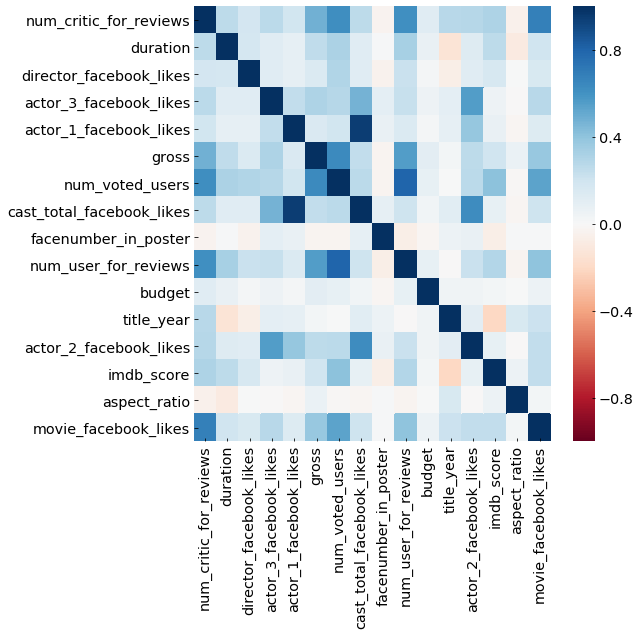

In [17]:
m2 = pd.DataFrame(Movie, columns = ['num_critic_for_reviews','duration','director_facebook_likes','actor_3_facebook_likes',
                                    'actor_1_facebook_likes','gross','num_voted_users', 'cast_total_facebook_likes',
                                    'facenumber_in_poster','num_user_for_reviews','budget','title_year','actor_2_facebook_likes',
                                    'imdb_score', 'aspect_ratio','movie_facebook_likes'])
Matrix = m2.corr()
plt.figure(figsize=(8, 8))
display(sns.heatmap(m2.corr(),vmin=-1, vmax=1,center=0,cmap="RdBu"))

# ========================= END OF SECTION =========================
